In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
import mrmr
import optuna
import torch
import gpytorch
import torchmetrics

In [2]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'))

In [3]:
df['ABETA_bl'].describe()

count     543.000000
mean     1015.935359
std       459.041016
min       203.000000
25%       648.000000
50%       888.500000
75%      1455.500000
max      1700.000000
Name: ABETA_bl, dtype: float64

In [4]:
# ratios of tau and ptau with a-beta
df['tau_ab_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['ptau_ab_ratio'] = df['PTAU_bl'] / df['ABETA_bl']

Taken from "CSF biomarkers of Alzheimer’s disease concord with amyloid-β PET and predict clinical progression: A study of fully automated immunoassays in BioFINDER and ADNI cohorts"

In [5]:
df['A+'] = df['ABETA_bl'].apply(lambda x: 1 if x < 880 else 0)
df['T+'] = df['ptau_ab_ratio'].apply(lambda x: 1 if x > 0.028 else 0)
df['N+'] = df['tau_ab_ratio'].apply(lambda x: 1 if x > 0.33 else 0)

In [6]:
df

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,tau_ab_ratio,ptau_ab_ratio,A+,T+,N+
0,101.20,10.08,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.011917,0.008881,0.006231,0.000712,0.000659,0.138289,0.013774,1,0,0
1,324.80,34.39,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.012666,0.008033,0.006029,0.000770,0.000699,0.416250,0.044073,1,1,1
2,490.40,53.18,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.012902,0.007799,0.005730,0.000804,0.000760,0.588928,0.063865,1,1,1
3,108.20,10.55,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.012782,0.009789,0.006613,0.000748,0.000675,0.183266,0.017869,1,0,0
4,247.10,24.78,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.012595,0.008533,0.005170,0.000675,0.000675,0.530144,0.053165,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,279.90,24.28,1700.0,-5.0,-1.0,-0.638261,12.0,0.557225,0.644524,1.064123,...,0.011478,0.009674,0.007555,0.000818,0.000764,0.164647,0.014282,0,0,0
539,305.00,25.05,1700.0,0.0,0.5,-0.460814,13.0,0.248483,0.434185,0.440843,...,0.011930,0.008579,0.006243,0.000678,0.000581,0.179412,0.014735,0,0,0
540,268.40,26.11,1700.0,5.0,1.0,-0.345749,13.0,1.094546,0.819451,0.996675,...,0.011329,0.008016,0.006976,0.000753,0.000723,0.157882,0.015359,0,0,0
541,300.10,26.59,1700.0,2.0,0.0,-0.334368,13.0,1.219117,1.001367,1.197789,...,0.010525,0.007063,0.005713,0.000815,0.000768,0.176529,0.015641,0,0,0


Plots to view cutoffs

[]

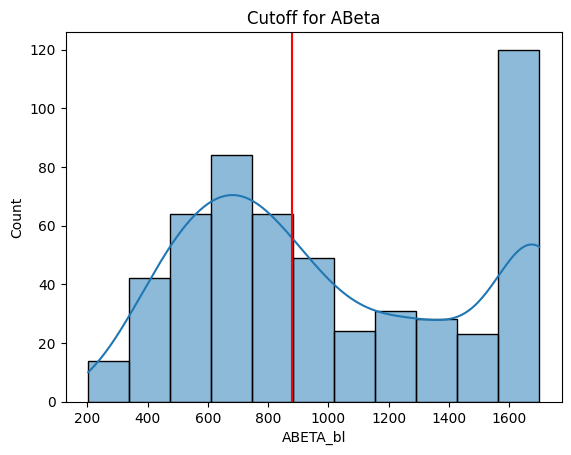

In [7]:
sns.histplot(df, x= 'ABETA_bl', kde=True)
plt.axvline(880, 0,120,color='red')
plt.title('Cutoff for ABeta')
plt.plot()

[]

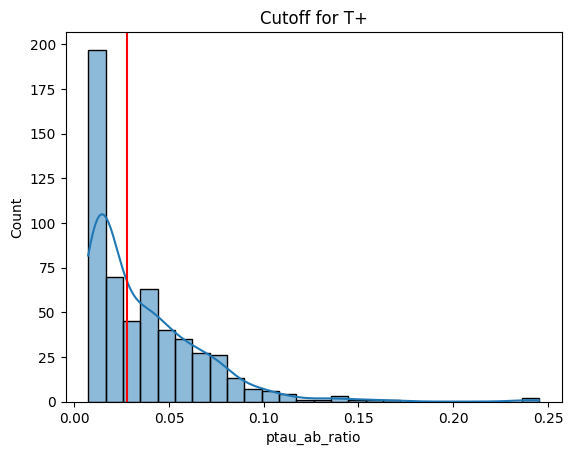

In [8]:
sns.histplot(df, x= 'ptau_ab_ratio', kde=True)
plt.axvline(0.028, 0,120,color='red')
plt.title('Cutoff for T+')
plt.plot()

[]

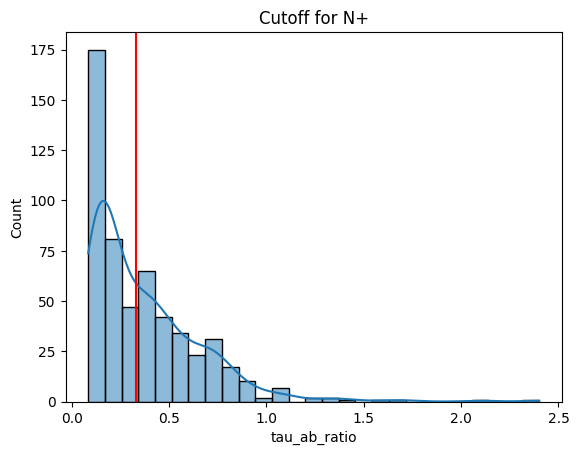

In [9]:
sns.histplot(df, x= 'tau_ab_ratio', kde=True)
plt.axvline(0.33, 0,120,color='red')
plt.title('Cutoff for N+')
plt.plot()

In [10]:
df['SUVr_Vermis_8.nii'].describe()

count    543.000000
mean       0.012274
std        0.001178
min        0.008156
25%        0.011467
50%        0.012260
75%        0.013009
max        0.015684
Name: SUVr_Vermis_8.nii, dtype: float64

In [11]:
df['tau_ab_ratio']

0      0.138289
1      0.416250
2      0.588928
3      0.183266
4      0.530144
         ...   
538    0.164647
539    0.179412
540    0.157882
541    0.176529
542    0.118140
Name: tau_ab_ratio, Length: 543, dtype: float64

In [10]:
df_1 = df.copy()

In [11]:
# keep only the SUVr and the A+, T+ and N+ cols
df = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'tau_ab_ratio', 'ptau_ab_ratio'])

df.head()

,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,SUVr_Angular_R.nii,...,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,A+,T+,N+
0,-1.036305,-0.944252,-0.943637,-0.956548,0.039320,0.038841,0.011054,0.014155,-1.536236,-1.434771,...,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659,1,0,0
1,1.193040,1.119475,1.146182,0.929328,0.057261,0.053242,0.013008,0.017184,1.734375,2.031744,...,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699,1,1,1
2,1.485349,1.479118,1.520871,1.377067,0.054272,0.053113,0.013620,0.016730,1.583530,1.174492,...,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760,1,1,1
3,-0.076402,-0.117696,-0.401966,-0.095506,0.044834,0.042373,0.011938,0.015462,-0.681419,-0.333145,...,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675,1,0,0
4,-0.176979,-0.460626,-0.096761,-0.212546,0.042674,0.039067,0.011457,0.013684,-0.176115,-0.568854,...,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675,1,1,1


# SVM Model

In [12]:
X = df.drop(columns=['A+', 'T+', 'N+']) # features
y = df['N+']  # target

scaler = StandardScaler()
X = scaler.fit_transform(X) # standaradize the SUVr features

X = pd.DataFrame(X, columns=df.drop(columns=['A+', 'T+', 'N+']).columns)  # needs to be a df for mRMR

features = mrmr.mrmr_classif(X, y, K=25)

100%|██████████| 25/25 [00:00<00:00, 37.17it/s]


In [15]:
features[:25]

['SUVr_Precuneus_L.nii',
 'SUVr_Fusiform_L.nii',
 'SUVr_Precuneus_R.nii',
 'SUVr_Temporal_Mid_L.nii',
 'SUVr_ACC_pre_L.nii',
 'SUVr_Angular_L.nii',
 'SUVr_ACC_sub_L.nii',
 'SUVr_Temporal_Inf_L.nii',
 'SUVr_Fusiform_R.nii',
 'SUVr_Temporal_Mid_R.nii',
 'SUVr_Parietal_Sup_L.nii',
 'SUVr_Frontal_Med_Orb_L.nii',
 'SUVr_ACC_sub_R.nii',
 'SUVr_Parietal_Inf_L.nii',
 'SUVr_Temporal_Sup_R.nii',
 'SUVr_Olfactory_L.nii',
 'SUVr_Rectus_L.nii',
 'SUVr_Occipital_Mid_L.nii',
 'SUVr_Frontal_Med_Orb_R.nii',
 'SUVr_Angular_R.nii',
 'SUVr_Rectus_R.nii',
 'SUVr_Temporal_Sup_L.nii',
 'SUVr_ACC_pre_R.nii',
 'SUVr_Occipital_Inf_L.nii',
 'SUVr_Insula_R.nii']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state =40)

In [14]:
clf = SVC(kernel='sigmoid', C = 1, gamma = 0.001) # sigmoid kernel so that we can use as binary

clf.fit(X_train, y_train) # train

y_pred = clf.predict(X_test) # predict

In [15]:
# metrics
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))
print("MCC: ", matthews_corrcoef(y_test, y_pred))


Accuracy: 0.908256880733945
Precision: 0.96
Recall: 0.8571428571428571
F1 Score:  0.9081873315363882
MCC:  0.8219030920784135


In [16]:
confusion_matrix(y_test, y_pred)

array([[51,  2],
       [ 8, 48]], dtype=int64)

In [17]:
# decision function
y_scores = clf.decision_function(X_test)

roc_auc_score(y_test, y_scores)

0.9669811320754716

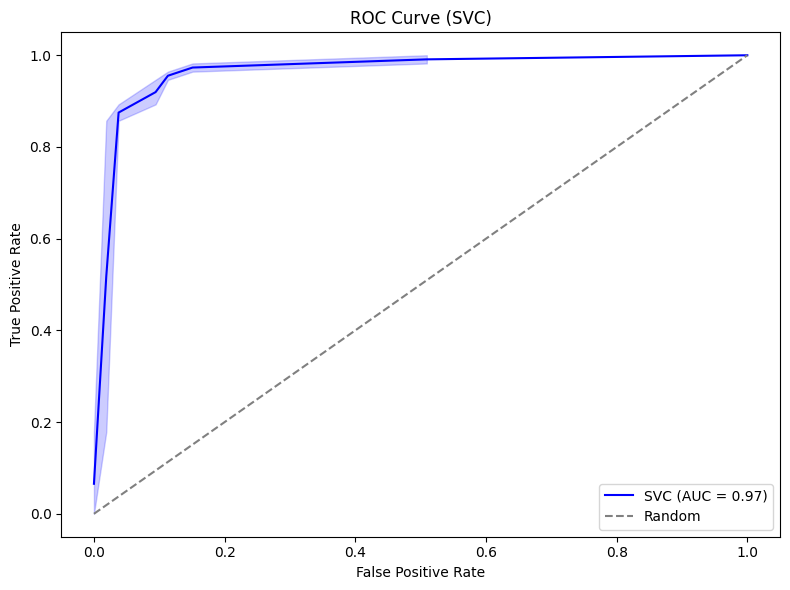

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_scores) # true/false positive rates
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f"SVC (AUC = {roc_auc:.2f})", color='blue')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVC)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# MultiOutput

multioutput, not to be confused with multi-task learning. We add the optimised parameteres here

In [ ]:
y = df.filter(['A+', 'T+', 'N+']) # targets

X = df.drop(columns=['A+', 'T+', 'N+']) 
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=df.drop(columns=['A+', 'T+', 'N+']).columns) 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state =7)

clf = MultiOutputClassifier(SVC(C=1, gamma='scale', kernel='sigmoid')) # mulitoutput classsifier

clf.fit(X_train, y_train)

,estimator,"SVC(C=1, kernel='sigmoid')"
,n_jobs,None
,C,1
,kernel,'sigmoid'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
for i, col in enumerate(y.columns):

    print(f"{col} accuracy: ",accuracy_score(y_pred[:,i], y_test[col]))

A+ accuracy:  0.7339449541284404
T+ accuracy:  0.8715596330275229
N+ accuracy:  0.8532110091743119


### Optimisation

We run grid search over a hyperparameter space. We add these to the previous cells

In [28]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['A+']  

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=df.drop(columns=['A+', 'T+', 'N+']).columns)  

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state =40)

In [29]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

clf = SVC(probability=True)

grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-10)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV accuracy):", grid_search.best_score_)

y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=scal

KeyboardInterrupt: 

# PCA 

Explored how PCA is for this task in reducing the feature space, but it is also useful for visualising the boundary. This is a small subtask and not a major part of the project

In [40]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['N+'] 

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=df.drop(columns=['A+', 'T+', 'N+']).columns)  # Preserve column names


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state =40)

pca = PCA(n_components=2) # Principal Companent Analysis with 2 components

pca.fit(X_train) # fit on trainig
X_train_np = pca.transform(X_train) # transform the training and test data
X_test_np = pca.transform(X_test)



In [41]:
clf = SVC(kernel='sigmoid', C = 1, gamma = 0.001) # set up SVC model

clf.fit(X_train_np, y_train)

y_pred = clf.predict(X_test_np)

In [42]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))


Accuracy: 0.8899082568807339
Precision: 0.9230769230769231
Recall: 0.8571428571428571


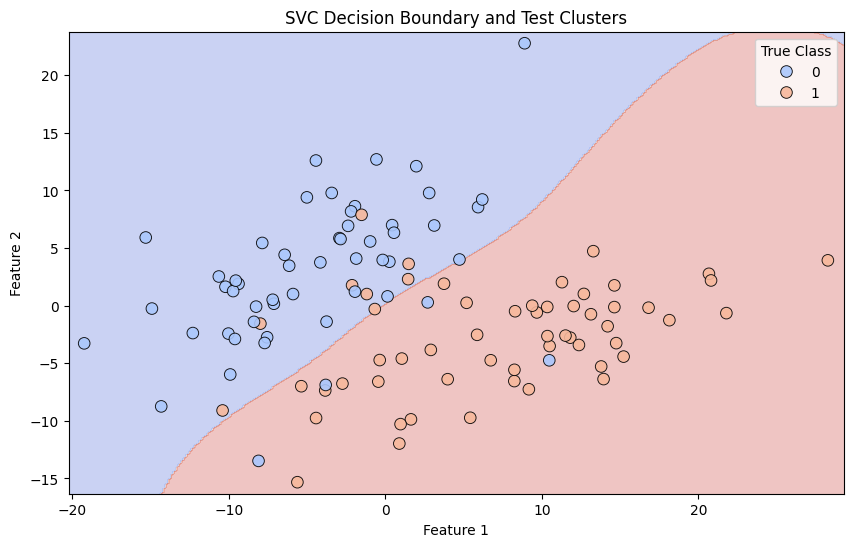

Accuracy: 0.8899082568807339
Precision: 0.9230769230769231
Recall: 0.8571428571428571


In [ ]:
# plotting the decision boundary

clf = SVC(kernel='rbf', C=1, gamma='scale', probability=True) 
clf.fit(X_train_np, y_train)

y_pred = clf.predict(X_test_np)

plt.figure(figsize=(10, 6))
x_min, x_max = X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1
y_min, y_max = X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_test_np[:, 0], y=X_test_np[:, 1], hue=y_test,
                palette='coolwarm', edgecolor='k', s=70, alpha=0.9)

plt.title("SVC Decision Boundary and Test Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='True Class')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


We now set up a custom Support vector machine , so we have more control over parameters and also so we can implement the multitask task.

In [ ]:
import torch
import gpytorch 
import torchmetrics

data_dir = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Class

In [ ]:
# SVM for single task classification
class SVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super().__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True) # weights
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True) # biases
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [24]:
df

,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,SUVr_Angular_R.nii,...,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,A+,T+,N+
0,-1.036305,-0.944252,-0.943637,-0.956548,0.039320,0.038841,0.011054,0.014155,-1.536236,-1.434771,...,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659,1,0,0
1,1.193040,1.119475,1.146182,0.929328,0.057261,0.053242,0.013008,0.017184,1.734375,2.031744,...,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699,1,1,1
2,1.485349,1.479118,1.520871,1.377067,0.054272,0.053113,0.013620,0.016730,1.583530,1.174492,...,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760,1,1,1
3,-0.076402,-0.117696,-0.401966,-0.095506,0.044834,0.042373,0.011938,0.015462,-0.681419,-0.333145,...,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675,1,0,0
4,-0.176979,-0.460626,-0.096761,-0.212546,0.042674,0.039067,0.011457,0.013684,-0.176115,-0.568854,...,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,0.150893,0.184938,-0.568143,-0.203841,0.042117,0.045545,0.013725,0.016478,-1.181372,-1.363305,...,0.018864,0.008398,0.011478,0.009674,0.007555,0.000818,0.000764,0,0,0
539,-0.654389,-0.317074,-0.687662,-0.797184,0.040523,0.041999,0.011000,0.014486,0.048740,0.589421,...,0.016943,0.008936,0.011930,0.008579,0.006243,0.000678,0.000581,0,0,0
540,-0.464856,-0.222718,-0.177684,-0.160735,0.046125,0.047444,0.010035,0.012790,-0.130244,-0.083937,...,0.015693,0.008374,0.011329,0.008016,0.006976,0.000753,0.000723,0,0,0
541,-1.550369,-1.016860,-1.233742,-1.138833,0.035993,0.039143,0.010660,0.014074,-0.867656,-0.780563,...,0.017387,0.008620,0.010525,0.007063,0.005713,0.000815,0.000768,0,0,0


### STL
Predict A+

In [ ]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['A+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [ ]:
model = SVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device) 

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device) 

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4) # optimizer

train_losses = []

# training loop
epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.9856
Epoch [2/100], Loss: 1.9598
Epoch [3/100], Loss: 1.9352
Epoch [4/100], Loss: 1.9103
Epoch [5/100], Loss: 1.8834
Epoch [6/100], Loss: 1.8546
Epoch [7/100], Loss: 1.8252
Epoch [8/100], Loss: 1.7963
Epoch [9/100], Loss: 1.7677
Epoch [10/100], Loss: 1.7382
Epoch [11/100], Loss: 1.7066
Epoch [12/100], Loss: 1.6737
Epoch [13/100], Loss: 1.6392
Epoch [14/100], Loss: 1.6051
Epoch [15/100], Loss: 1.5742
Epoch [16/100], Loss: 1.5454
Epoch [17/100], Loss: 1.5208
Epoch [18/100], Loss: 1.5007
Epoch [19/100], Loss: 1.4828
Epoch [20/100], Loss: 1.4657
Epoch [21/100], Loss: 1.4481
Epoch [22/100], Loss: 1.4294
Epoch [23/100], Loss: 1.4101
Epoch [24/100], Loss: 1.3881
Epoch [25/100], Loss: 1.3599
Epoch [26/100], Loss: 1.3282
Epoch [27/100], Loss: 1.3015
Epoch [28/100], Loss: 1.2810
Epoch [29/100], Loss: 1.2632
Epoch [30/100], Loss: 1.2450
Epoch [31/100], Loss: 1.2265
Epoch [32/100], Loss: 1.2092
Epoch [33/100], Loss: 1.1924
Epoch [34/100], Loss: 1.1750
Epoch [35/100], Loss: 1

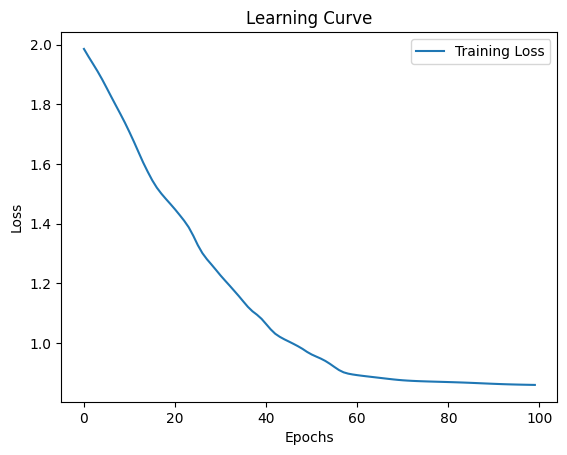

In [27]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [28]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.8133640552995391
Precision: 0.8252427184466019
Recall: 0.7906976744186046
F1 Score: 0.8076009501187648


In [29]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))

Test Accuracy: 0.7522935779816514
Test Precision: 0.7321428571428571
Test Recall: 0.7735849056603774
Test F1 Score: 0.7522935779816513


#### Predict T+

In [30]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['T+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [31]:
model = SVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.4580
Epoch [2/100], Loss: 1.4113
Epoch [3/100], Loss: 1.3711
Epoch [4/100], Loss: 1.3305
Epoch [5/100], Loss: 1.2877
Epoch [6/100], Loss: 1.2450
Epoch [7/100], Loss: 1.2039
Epoch [8/100], Loss: 1.1644
Epoch [9/100], Loss: 1.1218
Epoch [10/100], Loss: 1.0813
Epoch [11/100], Loss: 1.0465
Epoch [12/100], Loss: 1.0176
Epoch [13/100], Loss: 0.9888
Epoch [14/100], Loss: 0.9647
Epoch [15/100], Loss: 0.9449
Epoch [16/100], Loss: 0.9281
Epoch [17/100], Loss: 0.9123
Epoch [18/100], Loss: 0.8968
Epoch [19/100], Loss: 0.8825
Epoch [20/100], Loss: 0.8698
Epoch [21/100], Loss: 0.8586
Epoch [22/100], Loss: 0.8482
Epoch [23/100], Loss: 0.8381
Epoch [24/100], Loss: 0.8280
Epoch [25/100], Loss: 0.8180
Epoch [26/100], Loss: 0.8083
Epoch [27/100], Loss: 0.7990
Epoch [28/100], Loss: 0.7908
Epoch [29/100], Loss: 0.7842
Epoch [30/100], Loss: 0.7792
Epoch [31/100], Loss: 0.7759
Epoch [32/100], Loss: 0.7737
Epoch [33/100], Loss: 0.7723
Epoch [34/100], Loss: 0.7714
Epoch [35/100], Loss: 0

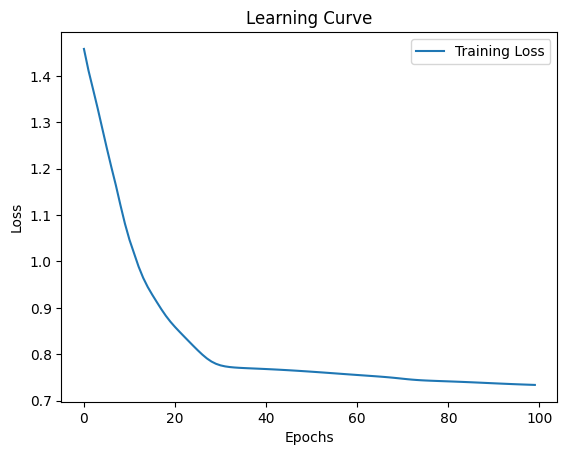

In [32]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [33]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))

Test Accuracy: 0.8715596330275229
Test Precision: 0.9245283018867925
Test Recall: 0.8305084745762712
Test F1 Score: 0.875


In [34]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.9009216589861752
Precision: 0.8955223880597015
Recall: 0.8910891089108911
F1 Score: 0.8933002481389578


#### Predict N+

In [35]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['N+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [36]:
model = SVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.5390
Epoch [2/100], Loss: 1.4867
Epoch [3/100], Loss: 1.4364
Epoch [4/100], Loss: 1.3877
Epoch [5/100], Loss: 1.3423
Epoch [6/100], Loss: 1.3004
Epoch [7/100], Loss: 1.2613
Epoch [8/100], Loss: 1.2246
Epoch [9/100], Loss: 1.1899
Epoch [10/100], Loss: 1.1574
Epoch [11/100], Loss: 1.1277
Epoch [12/100], Loss: 1.1021
Epoch [13/100], Loss: 1.0809
Epoch [14/100], Loss: 1.0633
Epoch [15/100], Loss: 1.0490
Epoch [16/100], Loss: 1.0374
Epoch [17/100], Loss: 1.0270
Epoch [18/100], Loss: 1.0166
Epoch [19/100], Loss: 1.0055
Epoch [20/100], Loss: 0.9939
Epoch [21/100], Loss: 0.9828
Epoch [22/100], Loss: 0.9729
Epoch [23/100], Loss: 0.9644
Epoch [24/100], Loss: 0.9569
Epoch [25/100], Loss: 0.9500
Epoch [26/100], Loss: 0.9434
Epoch [27/100], Loss: 0.9367
Epoch [28/100], Loss: 0.9297
Epoch [29/100], Loss: 0.9223
Epoch [30/100], Loss: 0.9144
Epoch [31/100], Loss: 0.9060
Epoch [32/100], Loss: 0.8977
Epoch [33/100], Loss: 0.8904
Epoch [34/100], Loss: 0.8844
Epoch [35/100], Loss: 0

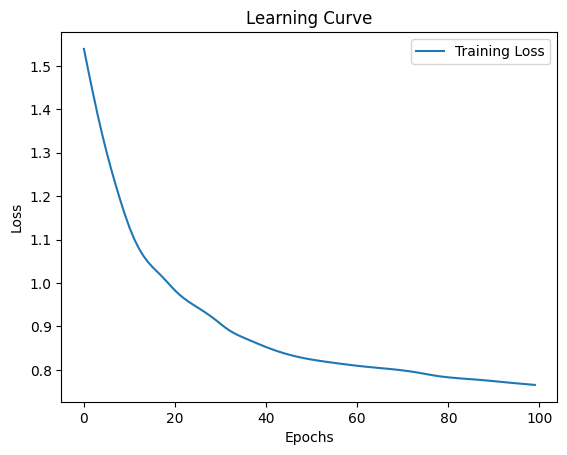

In [37]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [38]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.9009216589861752
Precision: 0.883248730964467
Recall: 0.8969072164948454
F1 Score: 0.8900255754475703


In [39]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))

Test Accuracy: 0.8807339449541285
Test Precision: 0.9387755102040817
Test Recall: 0.8214285714285714
Test F1 Score: 0.8761904761904763


## MTL

#### CLASS

In [ ]:
# ,ulitask SVM for multitask classification
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True) # shape here is the number of targets (3)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)
    

In [41]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df.filter(['A+', 'T+', 'N+'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([434, 166]) torch.Size([109, 166]) torch.Size([434, 3]) torch.Size([109, 3])


In [ ]:
model = MultitaskSVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.061911627281932204, weight_decay=8.933152146862321e-05) # from the hyperparameter optimization

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.5701
Epoch [2/100], Loss: 1.3031
Epoch [3/100], Loss: 1.0920
Epoch [4/100], Loss: 0.9593
Epoch [5/100], Loss: 0.8928
Epoch [6/100], Loss: 0.8675
Epoch [7/100], Loss: 0.8511
Epoch [8/100], Loss: 0.8361
Epoch [9/100], Loss: 0.8258
Epoch [10/100], Loss: 0.8173
Epoch [11/100], Loss: 0.8106
Epoch [12/100], Loss: 0.8074
Epoch [13/100], Loss: 0.8052
Epoch [14/100], Loss: 0.8029
Epoch [15/100], Loss: 0.8005
Epoch [16/100], Loss: 0.7982
Epoch [17/100], Loss: 0.7959
Epoch [18/100], Loss: 0.7938
Epoch [19/100], Loss: 0.7916
Epoch [20/100], Loss: 0.7892
Epoch [21/100], Loss: 0.7865
Epoch [22/100], Loss: 0.7835
Epoch [23/100], Loss: 0.7799
Epoch [24/100], Loss: 0.7755
Epoch [25/100], Loss: 0.7721
Epoch [26/100], Loss: 0.7700
Epoch [27/100], Loss: 0.7678
Epoch [28/100], Loss: 0.7649
Epoch [29/100], Loss: 0.7609
Epoch [30/100], Loss: 0.7570
Epoch [31/100], Loss: 0.7541
Epoch [32/100], Loss: 0.7516
Epoch [33/100], Loss: 0.7500
Epoch [34/100], Loss: 0.7491
Epoch [35/100], Loss: 0

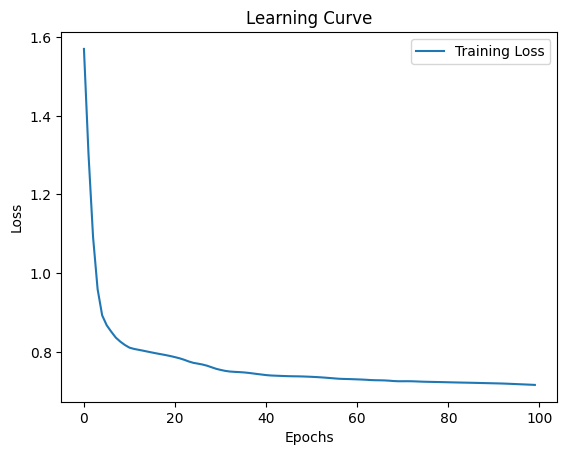

In [43]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [44]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    # For multitask (MTL) evaluation
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np, average='macro'))
    print("Recall:", recall_score(y_train_np, y_pred_np, average='macro'))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np, average='macro') * recall_score(y_train_np, y_pred_np, average='macro')) /
          (precision_score(y_train_np, y_pred_np, average='macro') + recall_score(y_train_np, y_pred_np, average='macro')))


Accuracy: 0.815668202764977
Precision: 0.9003768333489696
Recall: 0.9050800237060388
F1 Score: 0.9027223026543081


In [45]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np, average='macro'))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np, average='macro'))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np, average='macro') * recall_score(y_test_np,
                                                                  y_test_pred_np, average='macro')) / (
              precision_score(y_test_np, y_test_pred_np, average='macro') + recall_score(y_test_np,
                                                                        y_test_pred_np, average='macro')))

Test Accuracy: 0.7431192660550459
Test Precision: 0.9141075917546506
Test Recall: 0.8320141775930071
Test F1 Score: 0.8711310855134781


### MTL OPTIMISATION

In [46]:
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return plane_output

In [ ]:


# the hyperparamter optimization function
def objective(trial):

    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    #kernel_type = trial.suggest_categorical("kernel", ["RBF", "Matern", "RQ"])  # optional
    kernel_type = "RBF"
    num_epochs = 100

    if kernel_type == "RBF":
        kernel = gpytorch.kernels.RBFKernel()
    # elif kernel_type == "Matern":
    #     kernel = gpytorch.kernels.MaternKernel()
    # elif kernel_type == "RQ":
    #     kernel = gpytorch.kernels.RQKernel()
    # else:
    #     kernel = gpytorch.kernels.RBFKernel()  

    model = MultitaskSVM(X_train, y_train, kernel).to(device)
    loss_fn = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()


        if epoch % 10 == 0:
            trial.report(-loss.item(), step=epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    model.eval()
    with torch.no_grad():
        preds = model(X_test).cpu().numpy()
        true = y_test.cpu().numpy()


    preds_binary = (preds > 0).astype(int)
    true_binary = (true > 0).astype(int)


    f1_scores = [
        f1_score(true_binary[:, i], preds_binary[:, i]) for i in range(true.shape[1])
    ]
    mean_f1 = sum(f1_scores) / len(f1_scores)

    return mean_f1  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)


print("Best trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-18 09:27:09,210] A new study created in memory with name: no-name-eacee7bc-a1df-427a-af9d-fc04ed1ec262
[I 2025-07-18 09:27:09,891] Trial 0 finished with value: 0.4580567409514778 and parameters: {'lr': 0.00018378274271583155, 'weight_decay': 0.000730923950765583}. Best is trial 0 with value: 0.4580567409514778.
[I 2025-07-18 09:27:10,517] Trial 1 finished with value: 0.8850088183421517 and parameters: {'lr': 0.08945675030312328, 'weight_decay': 6.925406377404086e-05}. Best is trial 1 with value: 0.8850088183421517.
[I 2025-07-18 09:27:10,978] Trial 2 finished with value: 0.8771227668943657 and parameters: {'lr': 0.01033935297805761, 'weight_decay': 0.0003362081934853386}. Best is trial 1 with value: 0.8850088183421517.
[I 2025-07-18 09:27:11,436] Trial 3 finished with value: 0.7499036844831237 and parameters: {'lr': 0.0008598862912147976, 'weight_decay': 1.2626607581144095e-05}. Best is trial 1 with value: 0.8850088183421517.
[W 2025-07-18 09:27:11,780] Trial 4 failed with p

KeyboardInterrupt: 

## Sensitivity Test

This part is the wrong task for what we were trying to do. I have left it in but please ignore. 


class SVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super().__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [48]:
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [49]:
data_dir = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'))

df['tau_ab_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['ptau_ab_ratio'] = df['PTAU_bl'] / df['ABETA_bl']

df['A+'] = df['ABETA_bl'].apply(lambda x: 1 if x < 880 else 0)
df['T+'] = df['ptau_ab_ratio'].apply(lambda x: 1 if x > 0.028 else 0)
df['N+'] = df['tau_ab_ratio'].apply(lambda x: 1 if x > 0.33 else 0)

df = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'tau_ab_ratio', 'ptau_ab_ratio'])

df.head()
X = df.drop(columns=['A+', 'T+', 'N+'])

In [50]:

y = df.filter(['A+', 'T+', 'N+'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([434, 166]) torch.Size([109, 166]) torch.Size([434, 3]) torch.Size([109, 3])


Epoch [1/100], Loss: 1.2028
Epoch [2/100], Loss: 1.1707
Epoch [3/100], Loss: 1.1413
Epoch [4/100], Loss: 1.1154
Epoch [5/100], Loss: 1.0931
Epoch [6/100], Loss: 1.0749
Epoch [7/100], Loss: 1.0606
Epoch [8/100], Loss: 1.0481
Epoch [9/100], Loss: 1.0357
Epoch [10/100], Loss: 1.0222
Epoch [11/100], Loss: 1.0079
Epoch [12/100], Loss: 0.9930
Epoch [13/100], Loss: 0.9784
Epoch [14/100], Loss: 0.9637
Epoch [15/100], Loss: 0.9488
Epoch [16/100], Loss: 0.9344
Epoch [17/100], Loss: 0.9201
Epoch [18/100], Loss: 0.9072
Epoch [19/100], Loss: 0.8952
Epoch [20/100], Loss: 0.8811
Epoch [21/100], Loss: 0.8670
Epoch [22/100], Loss: 0.8552
Epoch [23/100], Loss: 0.8462
Epoch [24/100], Loss: 0.8388
Epoch [25/100], Loss: 0.8297
Epoch [26/100], Loss: 0.8199
Epoch [27/100], Loss: 0.8117
Epoch [28/100], Loss: 0.8062
Epoch [29/100], Loss: 0.8028
Epoch [30/100], Loss: 0.8006
Epoch [31/100], Loss: 0.7987
Epoch [32/100], Loss: 0.7967
Epoch [33/100], Loss: 0.7944
Epoch [34/100], Loss: 0.7921
Epoch [35/100], Loss: 0

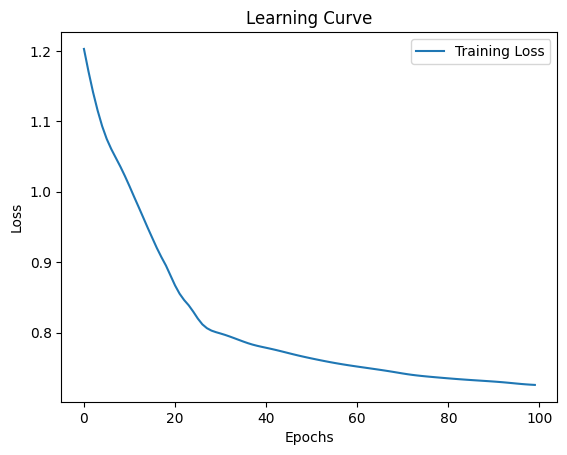

In [51]:
model = MultitaskSVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')
    
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [52]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("TRAIN:")
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np, average = 'macro'))
    print("Recall:", recall_score(y_train_np, y_pred_np, average = 'macro'))
    print("F1 Score:", 2 * (precision_score(y_train_np, y_pred_np, average = 'macro') * recall_score(y_train_np, y_pred_np, average = 'macro')) / (precision_score(y_train_np, y_pred_np, average = 'macro') + recall_score(y_train_np, y_pred_np, average = 'macro')))

TRAIN:
Accuracy: 0.7764976958525346
Precision: 0.9075646621368548
Recall: 0.8546459009362936
F1 Score: 0.8803107126735552


In [53]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("TEST:")
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))

TEST:
Test Accuracy: 0.7155963302752294


ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].

In [ ]:
def evaluate_with_margin_filter(model, X_test, y_test, epsilon=0.0):
    

    model.eval()
    with torch.no_grad():
        probs = model(X_test).squeeze() 
        
        confidence = torch.abs(probs - 0.5)  

        confidence_np = confidence.cpu().numpy()
        cutoff = np.percentile(confidence_np, 100 * epsilon)  
        mask = confidence > cutoff

        if mask.sum() == 0:
            print(f"No samples left after applying epsilon = {epsilon:.2f} (cutoff = {cutoff:.4f})") # handle case where no samples are left (not rare)
            return None, None, None, None, None

        y_filtered = y_test[mask]
        probs_filtered = probs[mask]
        y_pred = (probs_filtered > 0.5).float()

        y_pred_np = y_pred.cpu().numpy()
        y_true_np = y_filtered.cpu().numpy()
        y_probs_np = probs_filtered.cpu().numpy()

        accuracy = accuracy_score(y_true_np, y_pred_np)
        precision = precision_score(y_true_np, y_pred_np, average = 'macro')
        recall = recall_score(y_true_np, y_pred_np, average = 'macro')
        f1 = f1_score(y_true_np, y_pred_np, average = 'macro')
        coverage = mask.float().mean().item()
        auc = roc_auc_score(y_true_np, y_probs_np)
        fpr, tpr, _ = roc_curve(y_true_np, y_probs_np)

        coverage = mask.float().mean().item()

        print(f"\nEvaluation with epsilon = {epsilon:.2f} (Removed {epsilon:.0%} least confident, Coverage: {coverage:.2%})") 
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"AUROC:     {auc:.4f}")

        # Plot ROC curve
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve (epsilon = {epsilon:.2f})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        return accuracy, precision, recall, f1, auc


Evaluation with epsilon = 0.00 (Removed 0% least confident, Coverage: 99.69%)
Accuracy:  0.8589
Precision: 0.8624
Recall:    0.8605
F1 Score:  0.8588
AUROC:     0.9169


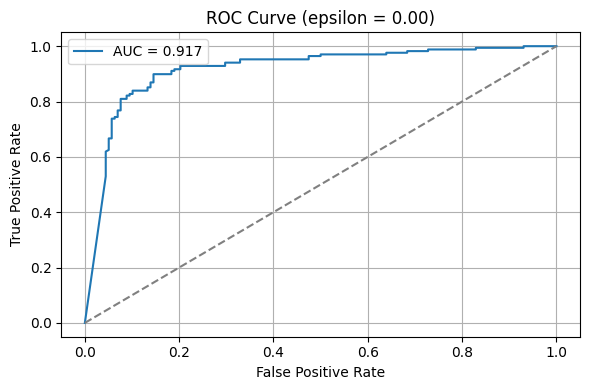

(0.8588957055214724,
 0.8624242424242424,
 0.8604581072935503,
 0.8588106805257409,
 0.9169303797468356)

In [55]:
evaluate_with_margin_filter(model, X_test,y_test, epsilon=0.0)


Evaluation with epsilon = 0.00 (Removed 0% least confident, Coverage: 99.69%)
Accuracy:  0.8589
Precision: 0.8624
Recall:    0.8605
F1 Score:  0.8588
AUROC:     0.9169


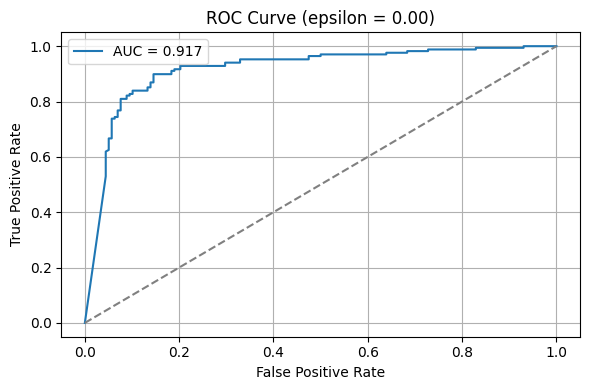


Evaluation with epsilon = 0.01 (Removed 1% least confident, Coverage: 98.78%)
Accuracy:  0.8669
Precision: 0.8702
Recall:    0.8682
F1 Score:  0.8668
AUROC:     0.9176


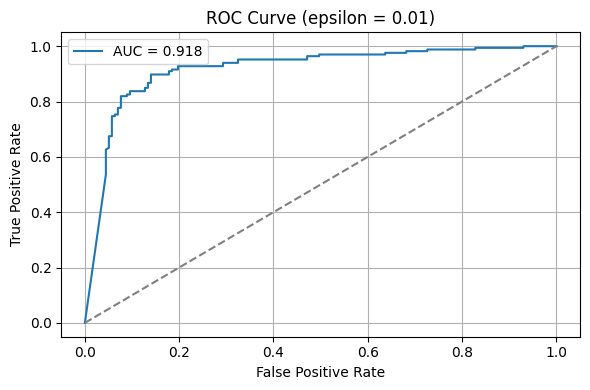


Evaluation with epsilon = 0.02 (Removed 2% least confident, Coverage: 97.86%)
Accuracy:  0.8719
Precision: 0.8752
Recall:    0.8734
F1 Score:  0.8718
AUROC:     0.9189


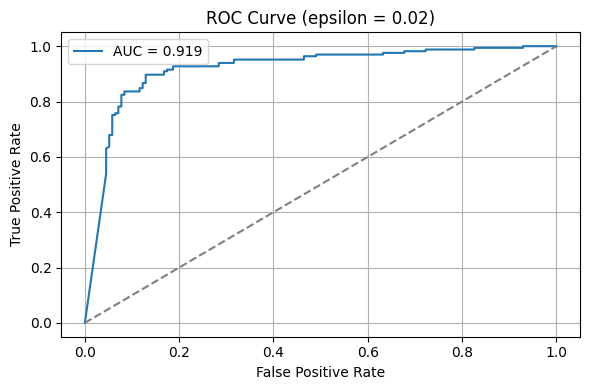


Evaluation with epsilon = 0.03 (Removed 3% least confident, Coverage: 96.94%)
Accuracy:  0.8707
Precision: 0.8741
Recall:    0.8721
F1 Score:  0.8706
AUROC:     0.9194


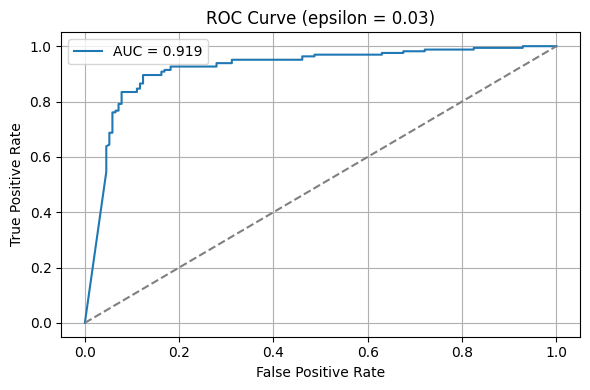


Evaluation with epsilon = 0.05 (Removed 5% least confident, Coverage: 94.80%)
Accuracy:  0.8742
Precision: 0.8774
Recall:    0.8748
F1 Score:  0.8740
AUROC:     0.9199


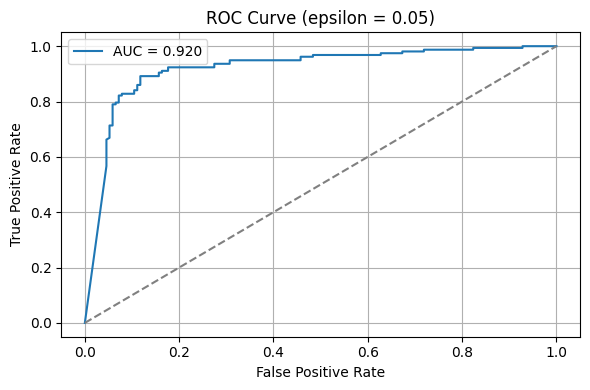


Evaluation with epsilon = 0.10 (Removed 10% least confident, Coverage: 89.91%)
Accuracy:  0.8844
Precision: 0.8877
Recall:    0.8847
F1 Score:  0.8842
AUROC:     0.9241


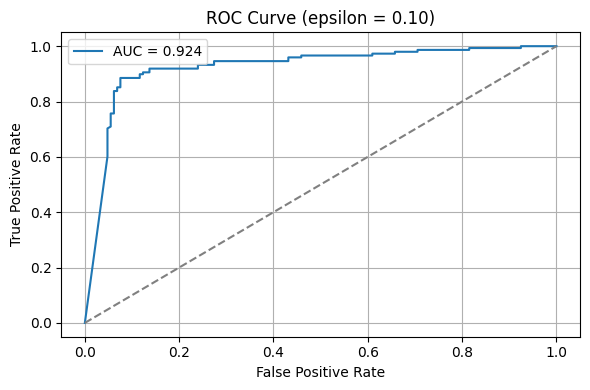


Evaluation with epsilon = 0.15 (Removed 15% least confident, Coverage: 85.02%)
Accuracy:  0.9065
Precision: 0.9080
Recall:    0.9063
F1 Score:  0.9064
AUROC:     0.9257


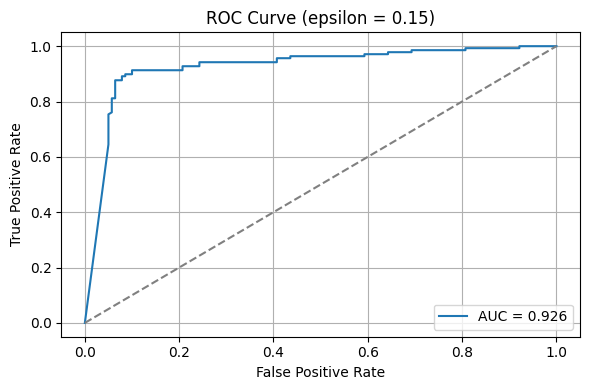


Evaluation with epsilon = 0.20 (Removed 20% least confident, Coverage: 79.82%)
Accuracy:  0.9195
Precision: 0.9199
Recall:    0.9192
F1 Score:  0.9194
AUROC:     0.9267


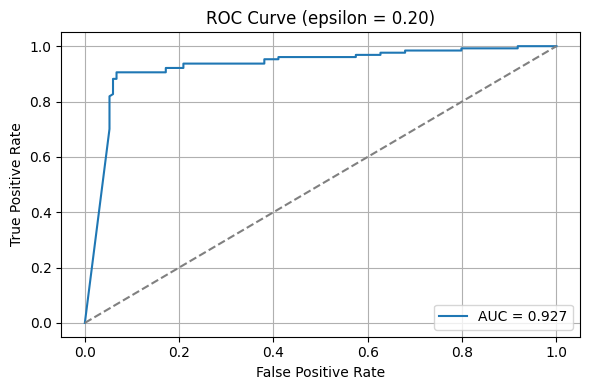


Evaluation with epsilon = 0.25 (Removed 25% least confident, Coverage: 74.92%)
Accuracy:  0.9184
Precision: 0.9189
Recall:    0.9183
F1 Score:  0.9183
AUROC:     0.9285


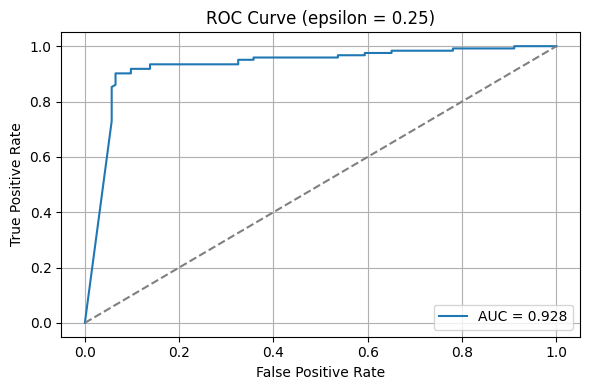


Evaluation with epsilon = 0.30 (Removed 30% least confident, Coverage: 69.72%)
Accuracy:  0.9254
Precision: 0.9258
Recall:    0.9253
F1 Score:  0.9254
AUROC:     0.9296


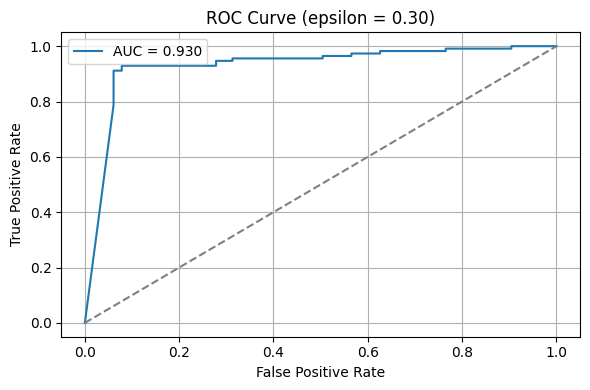


Evaluation with epsilon = 0.35 (Removed 35% least confident, Coverage: 64.83%)
Accuracy:  0.9292
Precision: 0.9293
Recall:    0.9290
F1 Score:  0.9291
AUROC:     0.9293


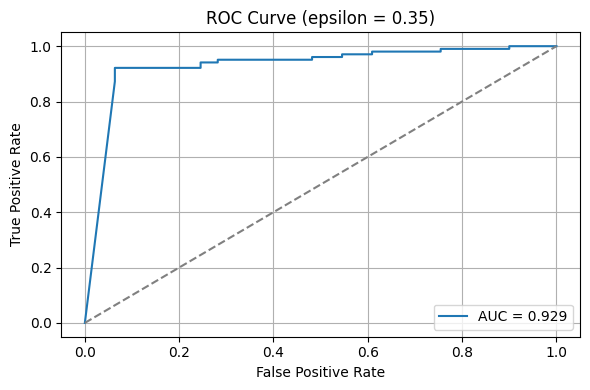


Evaluation with epsilon = 0.40 (Removed 40% least confident, Coverage: 59.33%)
Accuracy:  0.9227
Precision: 0.9227
Recall:    0.9227
F1 Score:  0.9227
AUROC:     0.9304


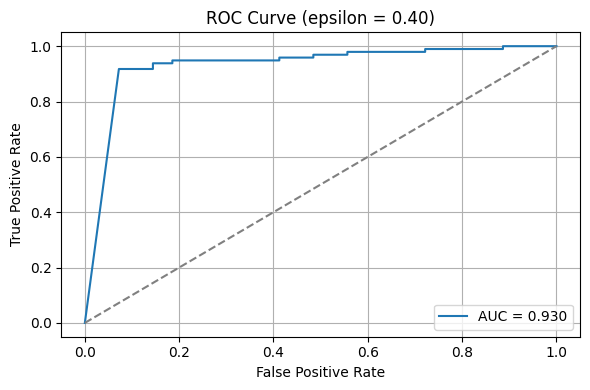

No samples left after applying epsilon = 0.45 (cutoff = 0.5000)
No samples left after applying epsilon = 0.50 (cutoff = 0.5000)


In [ ]:
accuracy = []
precision = []
recall = []
f1 = []
auroc = []
epsilon = [0.0, 0.01, 0.02, 0.03, 0.05, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5] # range of % to test
for eps in epsilon:
    a, p, r, f, aur = evaluate_with_margin_filter(model, X_test, y_test, epsilon=eps)
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    f1.append(f)
    auroc.append(aur)

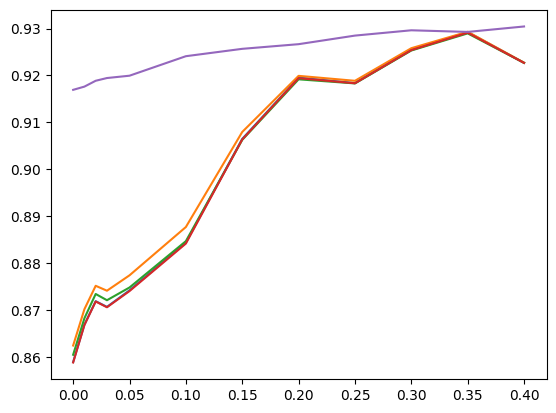

In [57]:
plt.plot(epsilon, accuracy)
plt.plot(epsilon, precision)
plt.plot(epsilon, recall)
plt.plot(epsilon, f1)
plt.plot(epsilon, auroc)

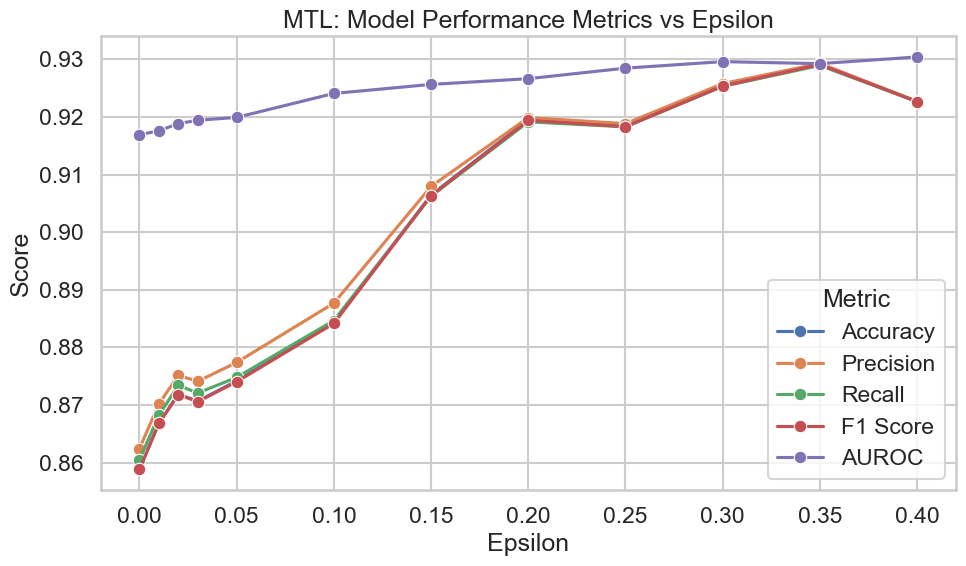

In [ ]:
df = pd.DataFrame({
    'epsilon': epsilon,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'AUROC': auroc
})

df_long = df.melt(id_vars='epsilon', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", context="talk")
sns.lineplot(data=df_long, x='epsilon', y='Score', hue='Metric', marker="o")

plt.title('MTL: Model Performance Metrics vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Proper cut-offs

This is the correct sensitivity test. We remove datapoints close the classification thresholds used to determine A+ T+ N+

In [116]:
class SVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super().__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [ ]:
# these are the cutoffs
apos_cutoffs = 880 
tpos_cutoffs = 0.028
npos_cutoffs = 0.33

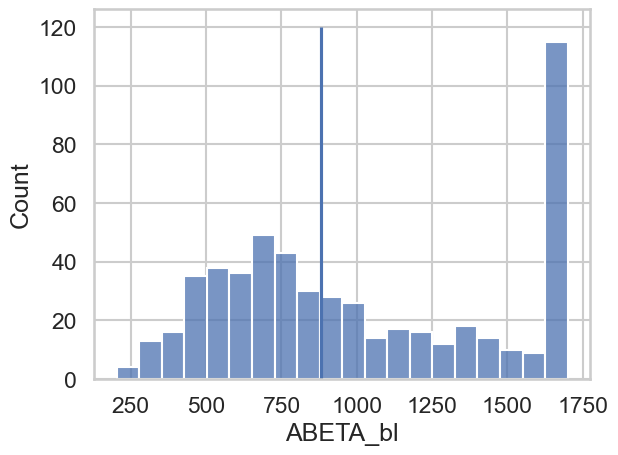

In [118]:
sns.histplot(df_1, x = 'ABETA_bl', bins=20)
plt.vlines(x = 880, ymin = 0, ymax=120)
plt.show()

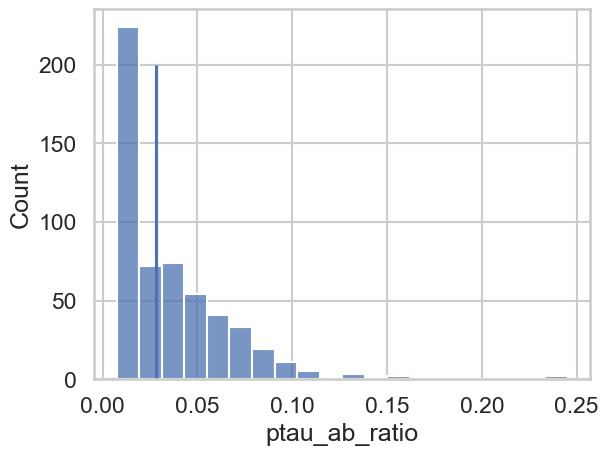

In [119]:
sns.histplot(df_1, x = 'ptau_ab_ratio', bins=20)
plt.vlines(x = 0.028, ymin = 0, ymax=200)
plt.show()

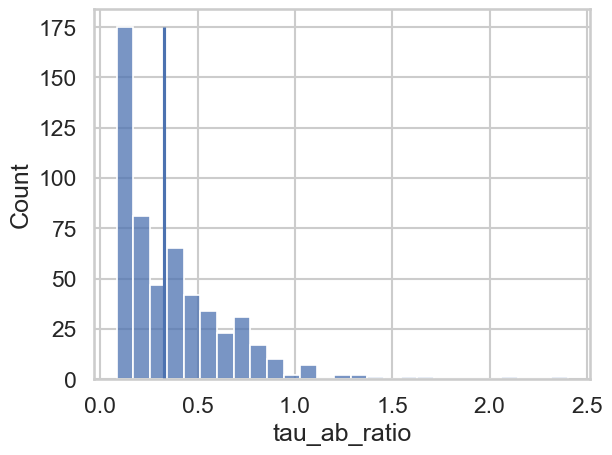

In [120]:
sns.histplot(df_1, x = 'tau_ab_ratio')
plt.vlines(x = 0.33, ymin = 0, ymax=175)
plt.show()

In [ ]:
# run repeats to get average perofmances for different percentages removed

percents = [1, 2, 3, 5, 10, 15, 20, 25, 30] 
results = []

for percent in percents:
    p = percent / 100 # acc percentages

    run_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auROC': [],
        'n_samples': []
    } # metrics storage

    for run in range(5): # 5 runs
        random_state = np.random.randint(0, 75)

        ab_mask = (df_1['ABETA_bl'] > (880 - 880 * p)) & (df_1['ABETA_bl'] < (880 + 880 * p)) # A+ mask
        df_filtered = df_1[~ab_mask].copy() #apply mask

        df_filtered = df_filtered.drop(columns=[
            'PTEDUCAT', 'TAU_bl', 'PTAU_bl', 'ABETA_bl', 'MMSE_bl',
            'EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl',
            'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl',
            'tau_ab_ratio', 'ptau_ab_ratio'
        ])

        # fit and train th model
        X = df_filtered.drop(columns=['A+', 'T+', 'N+'])
        y = df_filtered['A+']

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

        model = SVM(X_train_tensor, y_train_tensor, kernel=gpytorch.kernels.RBFKernel()).to(device)
        bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

        model.train()
        for epoch in range(100):
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = bhl(output, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
            y_pred_binary = (y_pred > 0.5).float()
            y_pred_np = y_pred_binary.cpu().numpy()
            y_test_np = y_test_tensor.cpu().numpy()

            acc = accuracy_score(y_test_np, y_pred_np)
            prec = precision_score(y_test_np, y_pred_np, zero_division=0)
            rec = recall_score(y_test_np, y_pred_np, zero_division=0)
            f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
            auroc = roc_auc_score(y_test_np, y_pred_np)

            run_metrics['accuracy'].append(acc)
            run_metrics['precision'].append(prec)
            run_metrics['recall'].append(rec)
            run_metrics['f1'].append(f1)
            run_metrics['auROC'].append(auroc)
            run_metrics['n_samples'].append(len(df_filtered))

    results.append({
        'percent': percent,
        'accuracy_mean': np.mean(run_metrics['accuracy']),
        'accuracy_std': np.std(run_metrics['accuracy']),
        'precision_mean': np.mean(run_metrics['precision']),
        'precision_std': np.std(run_metrics['precision']),
        'recall_mean': np.mean(run_metrics['recall']),
        'recall_std': np.std(run_metrics['recall']),
        'f1_mean': np.mean(run_metrics['f1']),
        'f1_std': np.std(run_metrics['f1']),
        'auROC_mean': np.mean(run_metrics['auROC']),
        'auROC_std': np.std(run_metrics['auROC']),
        'n_samples_avg': np.mean(run_metrics['n_samples'])
    }) # mean and std of metrics for each percent

results_df = pd.DataFrame(results)

print("A+ Prediction")
print(results_df)

A+ Prediction
   percent  accuracy_mean  accuracy_std  precision_mean  precision_std  \
0        1       0.852336      0.041544        0.842363       0.062142   
1        2       0.853333      0.019611        0.864554       0.034582   
2        3       0.838095      0.031298        0.856859       0.029339   
3        5       0.847059      0.038021        0.863427       0.041637   
4       10       0.829474      0.030069        0.860344       0.039577   
5       15       0.851163      0.030677        0.863002       0.046480   
6       20       0.905000      0.035882        0.905594       0.053545   
7       25       0.866667      0.025760        0.825632       0.072855   
8       30       0.907692      0.040118        0.852180       0.070615   

   recall_mean  recall_std   f1_mean    f1_std  auROC_mean  auROC_std  \
0     0.834574    0.061845  0.837846  0.057380    0.851659   0.044585   
1     0.817235    0.023210  0.839632  0.018959    0.850609   0.018033   
2     0.806592    0.071346

In [176]:
percents = [1, 2, 3, 5, 10, 15, 20, 25, 30]
results = []

for percent in percents:
    p = percent / 100

    run_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auROC': [],
        'n_samples': []
    }

    for run in range(5):
        random_state = np.random.randint(0, 75)

        ab_mask = (df_1['ptau_ab_ratio'] > (0.028 - 0.028 * p)) & (df_1['ptau_ab_ratio'] < (0.028 + 0.028 * p))
        df_filtered = df_1[~ab_mask].copy()

        df_filtered = df_filtered.drop(columns=[
            'PTEDUCAT', 'TAU_bl', 'PTAU_bl', 'ABETA_bl', 'MMSE_bl',
            'EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl',
            'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl',
            'tau_ab_ratio', 'ptau_ab_ratio'
        ])

        X = df_filtered.drop(columns=['A+', 'T+', 'N+'])
        y = df_filtered['T+']

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

        model = SVM(X_train_tensor, y_train_tensor, kernel=gpytorch.kernels.RBFKernel()).to(device)
        bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

        model.train()
        for epoch in range(100):
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = bhl(output, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
            y_pred_binary = (y_pred > 0.5).float()
            y_pred_np = y_pred_binary.cpu().numpy()
            y_test_np = y_test_tensor.cpu().numpy()

            acc = accuracy_score(y_test_np, y_pred_np)
            prec = precision_score(y_test_np, y_pred_np, zero_division=0)
            rec = recall_score(y_test_np, y_pred_np, zero_division=0)
            f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
            auroc = roc_auc_score(y_test_np, y_pred_np)

            run_metrics['accuracy'].append(acc)
            run_metrics['precision'].append(prec)
            run_metrics['recall'].append(rec)
            run_metrics['f1'].append(f1)
            run_metrics['auROC'].append(auroc)
            run_metrics['n_samples'].append(len(df_filtered))

    results.append({
        'percent': percent,
        'accuracy_mean': np.mean(run_metrics['accuracy']),
        'accuracy_std': np.std(run_metrics['accuracy']),
        'precision_mean': np.mean(run_metrics['precision']),
        'precision_std': np.std(run_metrics['precision']),
        'recall_mean': np.mean(run_metrics['recall']),
        'recall_std': np.std(run_metrics['recall']),
        'f1_mean': np.mean(run_metrics['f1']),
        'f1_std': np.std(run_metrics['f1']),
        'auROC_mean': np.mean(run_metrics['auROC']),
        'auROC_std': np.std(run_metrics['auROC']),
        'n_samples_avg': np.mean(run_metrics['n_samples'])
        
    })

results_df = pd.DataFrame(results)

print("T+ Prediction")
print(results_df)

T+ Prediction
   percent  accuracy_mean  accuracy_std  precision_mean  precision_std  \
0        1       0.872222      0.022981        0.906628       0.029390   
1        2       0.877778      0.019772        0.895354       0.039049   
2        3       0.870370      0.036571        0.858422       0.033916   
3        5       0.892453      0.041595        0.903225       0.035567   
4       10       0.912621      0.016246        0.933695       0.015371   
5       15       0.900990      0.028696        0.903699       0.044846   
6       20       0.934694      0.024659        0.951867       0.044272   
7       25       0.945263      0.027770        0.954251       0.028807   
8       30       0.933333      0.028974        0.969448       0.017876   

   recall_mean  recall_std   f1_mean    f1_std  auROC_mean  auROC_std  \
0     0.830220    0.053319  0.865237  0.025304    0.873335   0.022677   
1     0.848874    0.023736  0.871111  0.025618    0.878029   0.021636   
2     0.865277    0.081573

In [177]:
percents = [1, 2, 3, 5, 10, 15, 20, 25, 30]
results = []

for percent in percents:
    p = percent / 100

    run_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auROC': [],
        'n_samples': []
    }

    for run in range(5):
        random_state = np.random.randint(0, 75)

        ab_mask = (df_1['tau_ab_ratio'] > (0.33 - 0.33 * p)) & (df_1['tau_ab_ratio'] < (0.33 + 0.33 * p))
        df_filtered = df_1[~ab_mask].copy()

        df_filtered = df_filtered.drop(columns=[
            'PTEDUCAT', 'TAU_bl', 'PTAU_bl', 'ABETA_bl', 'MMSE_bl',
            'EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl',
            'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl',
            'tau_ab_ratio', 'ptau_ab_ratio'
        ])

        X = df_filtered.drop(columns=['A+', 'T+', 'N+'])
        y = df_filtered['N+']

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

        model = SVM(X_train_tensor, y_train_tensor, kernel=gpytorch.kernels.RBFKernel()).to(device)
        bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

        model.train()
        for epoch in range(100):
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = bhl(output, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
            y_pred_binary = (y_pred > 0.5).float()
            y_pred_np = y_pred_binary.cpu().numpy()
            y_test_np = y_test_tensor.cpu().numpy()

            acc = accuracy_score(y_test_np, y_pred_np)
            prec = precision_score(y_test_np, y_pred_np, zero_division=0)
            rec = recall_score(y_test_np, y_pred_np, zero_division=0)
            f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
            auroc = roc_auc_score(y_test_np, y_pred_np)

            run_metrics['accuracy'].append(acc)
            run_metrics['precision'].append(prec)
            run_metrics['recall'].append(rec)
            run_metrics['f1'].append(f1)
            run_metrics['auROC'].append(auroc)
            run_metrics['n_samples'].append(len(df_filtered))

    results.append({
        'percent': percent,
        'accuracy_mean': np.mean(run_metrics['accuracy']),
        'accuracy_std': np.std(run_metrics['accuracy']),
        'precision_mean': np.mean(run_metrics['precision']),
        'precision_std': np.std(run_metrics['precision']),
        'recall_mean': np.mean(run_metrics['recall']),
        'recall_std': np.std(run_metrics['recall']),
        'f1_mean': np.mean(run_metrics['f1']),
        'f1_std': np.std(run_metrics['f1']),
        'auROC_mean': np.mean(run_metrics['auROC']),
        'auROC_std': np.std(run_metrics['auROC']),
        'n_samples_avg': np.mean(run_metrics['n_samples'])
        
    })

results_df = pd.DataFrame(results)

print("N+ Prediction")
print(results_df)

N+ Prediction
   percent  accuracy_mean  accuracy_std  precision_mean  precision_std  \
0        1       0.885981      0.022430        0.853438       0.038399   
1        2       0.869811      0.027601        0.832853       0.042017   
2        3       0.856604      0.027601        0.853863       0.004733   
3        5       0.904762      0.032437        0.886723       0.036507   
4       10       0.886275      0.004803        0.865797       0.029030   
5       15       0.904082      0.008163        0.880054       0.038651   
6       20       0.928261      0.016268        0.930434       0.044138   
7       25       0.933333      0.033629        0.948444       0.037303   
8       30       0.952381      0.016836        0.939442       0.019463   

   recall_mean  recall_std   f1_mean    f1_std  auROC_mean  auROC_std  \
0     0.894130    0.063819  0.870594  0.019193    0.888192   0.022973   
1     0.871818    0.043298  0.850685  0.029342    0.870344   0.027087   
2     0.849051    0.056150